In [1]:
import datetime
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, Model, backend as K

from functools import partial
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('drive/MyDrive/TravelHack_Foundation/travelhack6.csv')
print(df.columns)
df.head()

Index(['Пол', 'День рождения', 'Возраст клиента', 'Заявка № ',
       'Дата бронирования', 'Дата начала тура', 'Год', 'Ночей', 'Вид тура',
       'Тип заявки', 'Страна тура', 'Регион отеля', 'Туристов',
       'Туристы, взрослые', 'Туристы, дети', 'Младенцы', 'Звездность',
       'Состав группы (Заявка) (Заявка)', 'Сумма в $', 'Наименование тура',
       'ИД клиента', 'Глубина продаж', 'Тип питания', 'Город Отеля',
       'Город отправления'],
      dtype='object')


,Пол,День рождения,Возраст клиента,Заявка №,Дата бронирования,Дата начала тура,Год,Ночей,Вид тура,Тип заявки,Страна тура,Регион отеля,Туристов,"Туристы, взрослые","Туристы, дети",Младенцы,Звездность,Состав группы (Заявка) (Заявка),Сумма в $,Наименование тура,ИД клиента,Глубина продаж,Тип питания,Город Отеля,Город отправления
0,мужской,2018-08-28 00:00:00,2.0,4803671,2021-02-07 20:44:00,2021-05-04 00:00:00,2021,12,Пляжный отдых,Пакет,Турция,NaN,4,2,2,0,4*,Семья,1718.64,Turkey Antalya LED,4197428,85.136111,All Inclusive,NaN,Санкт-Петербург
1,мужской,1991-04-25 00:00:00,29.0,4803671,2021-02-07 20:44:00,2021-05-04 00:00:00,2021,12,Пляжный отдых,Пакет,Турция,NaN,4,2,2,0,4*,Семья,1718.64,Turkey Antalya LED,4197429,85.136111,All Inclusive,NaN,Санкт-Петербург
2,мужской,1980-11-05 00:00:00,40.0,4803915,2021-02-08 09:03:00,2021-03-04 00:00:00,2021,6,Пляжный отдых,Пакет,Турция,Белек,3,2,1,0,5*,Семья,948.45,Turkey Antalya MOW,4197517,23.622917,AIP,Боазкент,Москва
3,мужской,2013-02-27 00:00:00,8.0,4806034,2021-02-08 19:46:00,2021-10-09 00:00:00,2021,11,Пляжный отдых,Пакет,Турция,Кемер,3,2,1,0,5*,Семья,2128.15,Turkey Antalya MOW,4197718,242.176389,UAI,Текирова,Москва
4,мужской,1968-10-06 00:00:00,52.0,4806034,2021-02-08 19:46:00,2021-10-09 00:00:00,2021,11,Пляжный отдых,Пакет,Турция,Кемер,3,2,1,0,5*,Семья,2128.15,Turkey Antalya MOW,4197719,242.176389,UAI,Текирова,Москва


In [3]:
for c in ['День рождения', 'Дата бронирования', 'Дата начала тура']:
    df[c] = pd.to_datetime(df[c], format='%Y-%m-%d %H:%M:%S')
df[['День рождения', 'Дата бронирования', 'Дата начала тура']].head()

,День рождения,Дата бронирования,Дата начала тура
0,2018-08-28,2021-02-07 20:44:00,2021-05-04
1,1991-04-25,2021-02-07 20:44:00,2021-05-04
2,1980-11-05,2021-02-08 09:03:00,2021-03-04
3,2013-02-27,2021-02-08 19:46:00,2021-10-09
4,1968-10-06,2021-02-08 19:46:00,2021-10-09


In [4]:
star_map = {
    '5*': 5,
    '4*': 4,
    '3*': 3,
    '2*': 2,
    '-': np.nan,
    '4*+': 4,
    '3*+': 3,
    'apt': 'apt',
    '0': np.nan,
    'HV1': 'HV',
    'Без звёзд': np.nan,
    'HV': 'HV',
    'HV2': 'HV',
    '3*-4*': 3,
    'BOUTIQUE': np.nan,
    '1*': 1,
    '2*super': 2,
    '2*+': 2,
    'Guest House': 'apt',
    'Std Apt': 'apt',
    '5*+': 5,
    '2*-3*': 2,
    '5* Deluxe': 5,
    '4*-5*': 4,
    'S-CLASS': np.nan,
    '3*super': 3,
    'SC': 'apt',
    'cat A': 4,
    'cat B': 3,
}

df['Звездность_fix'] = df['Звездность'].map(star_map)
df['Звездность_fix'].value_counts()

5      61344
4      27659
3      16269
2       1574
HV       764
apt      516
1         71
Name: Звездность_fix, dtype: int64

In [5]:
foods = df['Тип питания'].unique()
food_map = {
    'UAI': [
        'UAI', 'Ultra All Exclusive', 'All Inclusive Ultra', 'ULTRA ALL INCLUSIVE PLUS', 'Ultimate All Inclusive',
        'PREMIER ULTRA ALL INCLUSIVE', 'PREMIUM ALA CARTE ALL INCLUSIVE', 'Golden All Inclusive',
        'Platinum Plan All inclusive', 'SUPERIOR ALL INCLUSIVE', 'All Inclusive Premium',
        'ULTRA ALL INCLUSIVE WITH HIGH LEVEL', 'Emerald All Inclusive', 'Gold All Inclusive',
        'Super All Inclusive', 'All Inc Ultra Luxury', 'Diamond AI', 'PREMIUM ULTRA ALL INCLUSIVE',
        'AIP', 'AIS', 'Crystal Package',  'PRIVILEGED LIFE', 'Pure Indulgence Dine Around', 'Serenity Plan',
        'PRE.AI.LIFE STYLE', 'Premium All Inclusive', 'PALAZZO ALL INCLUSIVE'
    ],
    'AI': [
        'AI', 'All Inclusive', 'All Inclusive Dine Around',
        'Basic All Inclusive', 'Soft All Inclusive', "A'LA CARTE ALL INCLUSIVE", 'Light All Inclusive', 
        'All Inclusive Aqua', 'Limited all Inclusive', 'Island Plan All Inclusive',
        'Full Dine Around All Inclusive', 'VARU ALL INCLUSIVE', 'All inclusive Style',
        'All Inclusive Lite',  'Все включено СЕМЕЙНЫЙ', 'Все включено ПЛЯЖНЫЙ',
        'AI Light', 'AI NON ALCOHOL', 'ALL IN CONCEPT', 
        'LAI', 'LAI HB', 'FAI','DAI', 'DDAI', 'EAI', 'HB AI', 'FB AI', 'LAI FB', 'MAI'
    ],
    'FB': [
        'FB', 'BB+FB', 'FB + Оздоровит. путевка', 'FB+',  'FB + Лечение',
        'FB Beverage', 'FB + Общетерапевт.путевка',
        'FB + Антистресс', 'FB + Оздоровительная', 'FB + Отдых', 'FBT',
        'FB ресторан «Алтай» + Лечебная путевка', 'FB + Gala Dinner',
        'Полный пансион', 'Полный пансион + Лечение', 'Полный Пансион (шведский стол) + Отдых',
        'Полный Пансион+Отдых бассейн с термотерапией', 'Полный пансион+ Общетерапевтическая Лайт',
        'Полный пансион + Общетерапевтическая с Мацестой', 'Полный пансион + Общетерапевтическая без Мацесты',
        'Полный пансион + путевка Курортная', 'Полный Пансион + Смарт путевка', 'Полный Пансион + Серебряный возраст',
        'Full Board + drinks', 'Full Board Premium', 'Full Board Treatment Relax', 'Оздоровительная.',
        'FBp - Завтрак, обед, ужин (Premium)'
    ],
    'HB': [
        'HB', 'HB (завтрак+ужин)', 'HB + Оздоровит. путевка', 'HB+', 'HB Plus',
        'HB (завтрак+обед)', 'HB Beverage', 'BB+HB', 'HBT', 'HB + Лечение',
        'PR - Завтрак, ужин (Premium)',
        'Полупансион (завтрак+ужин)', 'Half Board Platinum', 'Half board + drinks',
        'Half Board Dine Around', 'Half Board Premium', 'Half Board Beach', 'Half Board Treatment Relax'
    ],
    'BB': [
        'Завтрак', 'BB', 'BB Continental', 'BB + Оздоровит. путевка', 'BB Пляжный',
        'Breakfast', 'Bed And Breakfast Plus'
    ],
    'RO': [
        'RO', 'RO + Оздоровительная курсовка', 'RO + Оздоровительная путевка', 'Only Bed', 'Bed Only', 'Без питания'
    ]
}
t = [vv for v in food_map.values() for vv in v]
print(len(t) == len(set(t)))
set(foods) - set([vv for v in food_map.values() for vv in v])

True


{'0',
 'AXI',
 'Al + лечение',
 'As Per Program',
 'HCI',
 'HEA',
 'LUXME',
 'SC',
 nan,
 'По программе',
 'По программе +'}

In [6]:
def fix_food(f):
    for key in food_map:
        if f in food_map[key]:
            return key
df['Тип питания fix'] = df['Тип питания'].apply(fix_food)
df['Тип питания fix'].value_counts()

AI     44930
UAI    30551
HB     12459
BB     11874
FB      3336
RO      2362
Name: Тип питания fix, dtype: int64

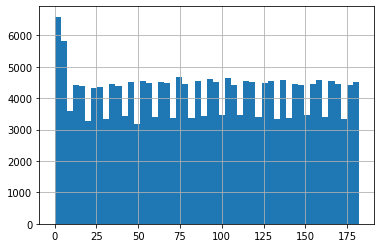

In [7]:
def time_diff(row):
    d1 = row['День рождения'].dayofyear
    d2 = row['Дата начала тура'].dayofyear
    if d1>d2: d2,d1=d1,d2
    return d2-d1 if d2-d1<183 else d1+365-d2
df['Начало тура ДР'] = df.apply(time_diff, axis=1)
df['Начало тура ДР'].hist(bins=50);

In [8]:
df = df.rename(columns={
    'Состав группы (Заявка) (Заявка)': 'Состав группы',
    'Заявка № ': 'Заявка',
    'Сумма в $': 'Сумма',
    'Город Отеля': 'Город отеля'
})

In [9]:
df['Месяц Бронирования'] = df['Дата бронирования'].apply(lambda x: x.month)
df['Месяц Выезда'] = df['Дата бронирования'].apply(lambda x: x.month)

In [10]:
df.loc[df['Возраст клиента']>100, 'День рождения'] = np.nan
df.loc[df['Возраст клиента']>100, 'Возраст клиента'] = np.nan

df['День рождения'].fillna(df['Дата бронирования'] -  datetime.timedelta(30*360), inplace=True)
df['Возраст клиента'].fillna(30, inplace=True)

In [12]:
df['Пол'] = (df['Пол']=='мужской').astype(int)
df['Пол'].value_counts()

0    124300
1     85309
Name: Пол, dtype: int64

In [11]:
f = [
    'ИД клиента',
    'Пол',
    'Возраст клиента',
    'Начало тура ДР',
    'Месяц Бронирования',
    'Месяц Выезда',
    'Туристов',
    'Туристы, взрослые',
    'Туристы, дети',
    'Младенцы',
    'Состав группы',
    'Город отправления'
]

t = [
    'Ночей',
    'Сумма',
    'Звездность_fix',
    'Тип питания fix',
    'Страна тура',
    'Регион отеля',
    'Город отеля',
]

In [16]:
df_ = df[f+t].copy()
df_.head()

,ИД клиента,Пол,Возраст клиента,Начало тура ДР,Месяц Бронирования,Месяц Выезда,Туристов,"Туристы, взрослые","Туристы, дети",Младенцы,Состав группы,Город отправления,Ночей,Сумма,Звездность_fix,Тип питания fix,Страна тура,Регион отеля,Город отеля
0,4197428,1,2.0,116.0,2,2,4,2,2,0,Семья,Санкт-Петербург,12,1718.64,4,AI,Турция,NaN,NaN
1,4197429,1,29.0,9.0,2,2,4,2,2,0,Семья,Санкт-Петербург,12,1718.64,4,AI,Турция,NaN,NaN
2,4197517,1,40.0,118.0,2,2,3,2,1,0,Семья,Москва,6,948.45,5,UAI,Турция,Белек,Боазкент
3,4197718,1,8.0,141.0,2,2,3,2,1,0,Семья,Москва,11,2128.15,5,UAI,Турция,Кемер,Текирова
4,4197719,1,52.0,2.0,2,2,3,2,1,0,Семья,Москва,11,2128.15,5,UAI,Турция,Кемер,Текирова


In [18]:
df_ = df_.fillna('nan')

In [19]:
first_tour = df.sort_values('Дата бронирования').groupby('ИД клиента').first()
first_tour.shape

(193276, 29)

In [20]:
not_first_tour = df[~df['Заявка'].isin(first_tour['Заявка'])]
not_first_tour.shape

(12050, 30)

In [ ]:
first_tour

In [31]:
t_next = [x + '_next' for x in t]
not_first_tour = not_first_tour.rename(columns={x: x + '_next' for x in t})

In [34]:
merged = first_tour.merge(not_first_tour[['ИД клиента'] + t_next], on='ИД клиента', how='right')
merged.shape

(12050, 37)

In [35]:
merged.head()

,ИД клиента,Пол,День рождения,Возраст клиента,Заявка,Дата бронирования,Дата начала тура,Год,Ночей,Вид тура,Тип заявки,Страна тура,Регион отеля,Туристов,"Туристы, взрослые","Туристы, дети",Младенцы,Звездность,Состав группы,Сумма,Наименование тура,Глубина продаж,Тип питания,Город отеля,Город отправления,Звездность_fix,Тип питания fix,Начало тура ДР,Месяц Бронирования,Месяц Выезда,Ночей_next,Сумма_next,Звездность_fix_next,Тип питания fix_next,Страна тура_next,Регион отеля_next,Город отеля_next
0,4208819,1,1985-05-12,35.0,4808190,2021-02-09 17:38:00,2021-06-06,2021,11,Пляжный отдых,Пакет,Турция,Аланья,4,4,0,0,3*,Группа,1121.02,Turkey Antalya MOW,116.265278,RO,Аланья,Москва,3,RO,25.0,2,2,11,972.86,3,RO,Турция,Аланья,Аланья
1,1126158,1,1989-05-13,31.0,3530270,2019-03-12 17:13:00,2019-06-06,2019,7,Пляжный отдых,Пакет,Турция,Мармарис,4,2,1,1,5*,Семья,1395.95,Turkey Dalaman MOW,85.282639,All Inclusive,Сителер,Москва,5,AI,24.0,3,3,7,1841.63,5,AI,Турция,Мармарис,Армуталан
2,1126159,1,2014-12-10,6.0,3530270,2019-03-12 17:13:00,2019-06-06,2019,7,Пляжный отдых,Пакет,Турция,Мармарис,4,2,1,1,5*,Семья,1395.95,Turkey Dalaman MOW,85.282639,All Inclusive,Сителер,Москва,5,AI,178.0,3,3,7,1841.63,5,AI,Турция,Мармарис,Армуталан
3,3809190,1,2017-08-18,3.0,4626251,2020-09-09 14:32:00,2020-09-27,2020,12,VIP,Premium,Турция,Белек,4,2,2,0,5*,Семья,3640.11,TUI Premium Antalya MOW,17.394444,UAI,Белек Центр,Москва,5,UAI,41.0,9,9,12,5845.59,5,UAI,Турция,Фетхие,Фетхие
4,3809191,1,1981-09-29,39.0,4626251,2020-09-09 14:32:00,2020-09-27,2020,12,VIP,Premium,Турция,Белек,4,2,2,0,5*,Семья,3640.11,TUI Premium Antalya MOW,17.394444,UAI,Белек Центр,Москва,5,UAI,1.0,9,9,12,5845.59,5,UAI,Турция,Фетхие,Фетхие


In [37]:
from sklearn.model_selection import train_test_split
merged_train, merged_test = train_test_split(merged)
merged_train.shape, merged_test.shape

((9037, 37), (3013, 37))

In [48]:
f[1:]+t

['Пол',
 'Возраст клиента',
 'Начало тура ДР',
 'Месяц Бронирования',
 'Месяц Выезда',
 'Туристов',
 'Туристы, взрослые',
 'Туристы, дети',
 'Младенцы',
 'Состав группы',
 'Город отправления',
 'Ночей',
 'Сумма',
 'Звездность_fix',
 'Тип питания fix',
 'Страна тура',
 'Регион отеля',
 'Город отеля']

In [41]:
t_next

['Ночей_next',
 'Сумма_next',
 'Звездность_fix_next',
 'Тип питания fix_next',
 'Страна тура_next',
 'Регион отеля_next',
 'Город отеля_next']

In [65]:
merged_train = merged_train.replace({None: 'nan'})
merged_test = merged_test.replace({None: 'nan'})

In [49]:
merged_train[f[1:]+t]

,Пол,Возраст клиента,Начало тура ДР,Месяц Бронирования,Месяц Выезда,Туристов,"Туристы, взрослые","Туристы, дети",Младенцы,Состав группы,Город отправления,Ночей,Сумма,Звездность_fix,Тип питания fix,Страна тура,Регион отеля,Город отеля
2169,1,21.0,42.0,4,4,2,2,0,0,Группа,Москва,11,1139.53,3,BB,Болгария,Бургас,Несебр и Равда
8712,0,14.0,17.0,2,2,3,2,1,0,Семья,Москва,14,3519.49,None,None,Испания,None,None
1903,1,40.0,50.0,5,5,3,2,0,1,Семья,Москва,7,1961.41,None,None,Греция,None,None
10264,0,34.0,76.0,2,2,2,2,0,0,Пары,Москва,10,2454.51,None,None,Кипр,None,None
2266,1,71.0,149.0,8,8,2,2,0,0,Пары,Сочи,3,158.43,3,BB,Россия,Санкт-Петербург,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8405,0,9.0,13.0,2,2,5,2,2,1,Семья,Анталья,14,8145.00,5,AI,Турция,Белек,Белек Центр
7640,0,47.0,97.0,1,1,3,2,1,0,Семья,Москва,7,1862.00,5,UAI,Турция,Кемер,Бельдиби
11987,0,34.0,126.0,5,5,3,2,1,0,Семья,Москва,12,1149.34,3,FB,Россия,Сочи,Имеретинская Бухта
7918,0,47.0,16.0,6,6,4,3,1,0,Семья,Москва,12,3164.00,None,None,Турция,None,None


In [66]:
x_train, x_test = merged_train[f[1:]+t].values, merged_test[f[1:]+t].values
y_train, y_test = merged_train[t_next].values, merged_test[t_next].values

In [44]:
!pip install catboost

     |████████████████████████████████| 67.3MB 57kB/s 


In [46]:
import catboost

In [50]:
clf = catboost.CatBoostClassifier(cat_features=[9,10,13,14,15,16,17], eval_metric='mse')

array([[1, 21.0, 42.0, ..., 'Болгария', 'Бургас', 'Несебр и Равда'],
       [0, 14.0, 17.0, ..., 'Испания', None, None],
       [1, 40.0, 50.0, ..., 'Греция', None, None],
       ...,
       [0, 34.0, 126.0, ..., 'Россия', 'Сочи', 'Имеретинская Бухта'],
       [0, 47.0, 16.0, ..., 'Турция', None, None],
       [0, 58.0, 101.0, ..., 'Турция', 'Кемер', 'Гейнюк']], dtype=object)

In [68]:
y_test[:,0]

array([12, 11, 10, ..., 7, 14, 12], dtype=object)

In [67]:
clf.fit(x_train, y_train[:,0], eval_set=(x_test, y_test[:,0]))

Learning rate set to 0.112836
0:	learn: 3.0485755	test: 3.0558139	best: 3.0558139 (0)	total: 5.14s	remaining: 1h 25m 37s
1:	learn: 2.8601064	test: 2.8701374	best: 2.8701374 (1)	total: 7.37s	remaining: 1h 1m 18s
2:	learn: 2.7535660	test: 2.7643524	best: 2.7643524 (2)	total: 8.31s	remaining: 46m 2s
3:	learn: 2.6799863	test: 2.6905907	best: 2.6905907 (3)	total: 9.21s	remaining: 38m 13s
4:	learn: 2.6036876	test: 2.6153257	best: 2.6153257 (4)	total: 14.2s	remaining: 46m 56s
5:	learn: 2.5494549	test: 2.5609359	best: 2.5609359 (5)	total: 15.8s	remaining: 43m 35s
6:	learn: 2.5028342	test: 2.5154847	best: 2.5154847 (6)	total: 21.1s	remaining: 49m 50s
7:	learn: 2.4708419	test: 2.4832304	best: 2.4832304 (7)	total: 21.4s	remaining: 44m 16s
8:	learn: 2.4428768	test: 2.4551734	best: 2.4551734 (8)	total: 24.8s	remaining: 45m 35s
9:	learn: 2.4106391	test: 2.4238624	best: 2.4238624 (9)	total: 30.1s	remaining: 49m 43s
10:	learn: 2.3840008	test: 2.3976760	best: 2.3976760 (10)	total: 35.6s	remaining: 53m 

KeyboardInterrupt: ignored